# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [64]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package

from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import category_encoders

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter

### **Loading the catalog**

In [65]:
# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name='appointment_attendance')

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [113]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [114]:
def convert_to_fy(timestamp):
    if timestamp.month >=4:
        return timestamp.year
    else:
        return timestamp.year - 1 
combined_df['FY_YEAR'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH'], format="%b%Y").map(lambda x: f"FY{convert_to_fy(x)}")

In [115]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']

combined_df_copy = combined_df[needed_cols].copy()

# Replacing months values to FY- years
def make_financial_years(df, column_name):
    mapping = {
        'APR2021': 'FY2021', 'MAY2021': 'FY2021', 'JUN2021': 'FY2021', 'JUL2021': 'FY2021', 'AUG2021': 'FY2021', 'SEP2021': 'FY2021',
        'OCT2021': 'FY2021', 'NOV2021': 'FY2021', 'DEC2021': 'FY2021', 'JAN2022': 'FY2021', 'FEB2022': 'FY2021', 'MAR2022': 'FY2021',
        'APR2022': 'FY2022', 'MAY2022': 'FY2022', 'JUN2022': 'FY2022', 'JUL2022': 'FY2022', 'AUG2022': 'FY2022', 'SEP2022': 'FY2022',
        'OCT2022': 'FY2022', 'NOV2022': 'FY2022', 'DEC2022': 'FY2022', 'JAN2023': 'FY2022', 'FEB2023': 'FY2022', 'MAR2023': 'FY2022',
        'APR2023': 'FY2023', 'MAY2023': 'FY2023', 'JUN2023': 'FY2023', 'JUL2023': 'FY2023', 'AUG2023': 'FY2023'
    }
    
    df[column_name] = df[column_name].map(mapping)
    return df
    
combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021']
combined_df_copy['APPOINTMENT_MONTH'].unique()

array(['APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021', 'SEP2021',
       'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022', 'MAR2022',
       'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022', 'SEP2022',
       'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023', 'MAR2023',
       'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [116]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).sum().reset_index()

# Converting months into FY-years
attended_df = make_financial_years(attended_df, 'FY_YEAR')

# Dataframe for appointments attended
attended_df_mean = attended_df.groupby(['ICB_NAME','FY_YEAR']).mean()
attended_df_mean['COUNT_OF_APPOINTMENTS'] = attended_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
attended_df_mean.head()

ValueError: cannot reindex on an axis with duplicate labels

2023 ka average match islie nahe ho raha hai kyunki divide 12 se nahe balki 5 se ho raha hai kyunki data me august/23 tak ka data ha FY23 k lie

In [69]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).sum().reset_index()

# Converting months into FY-years
do_not_attend_df = make_financial_years(do_not_attend_df, 'FY_YEAR')

# Dataframe for appointments DNA
dna_df_mean = do_not_attend_df.groupby(['ICB_NAME','FY_YEAR']).mean()
dna_df_mean['COUNT_OF_APPOINTMENTS'] = dna_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
dna_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                14708.5
                                                   FY2022                16003.8
                                                   FY2023                14901.6
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                15846.7
                                                   FY2022                19536.8

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [70]:
# Convert the 'count_column' to numeric
attended_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(attended_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_attended_2021 = attended_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_attended_2022 = attended_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_attended_2023_april_august = attended_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_attended = attended_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended_2021.item()} is the National average for attended appointments(FY-2021)')
print(f'{National_average_attended_2022.item()} is the National average for attended appointments(FY-2022)')
print(f'{National_average_attended_2023_april_august.item()} is the National average for attended appointments(FY-2023, april-august)')

SNEE_average_attended

579332.27 is the National average for attended appointments(FY-2021)
608099.22 is the National average for attended appointments(FY-2022)
591085.91 is the National average for attended appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,450111.8
FY2022,465021.9
FY2023,448269.2


#### **2. Not attended (DNA) Appointments**

In [71]:
# Convert the 'count_column' to numeric
dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_dna_2021 = dna_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_dna_2022 = dna_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_dna_2023_april_august = dna_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_DNA = dna_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

27252.8 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
29004.74 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,16323.2
FY2022,17822.6
FY2023,14968.0


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

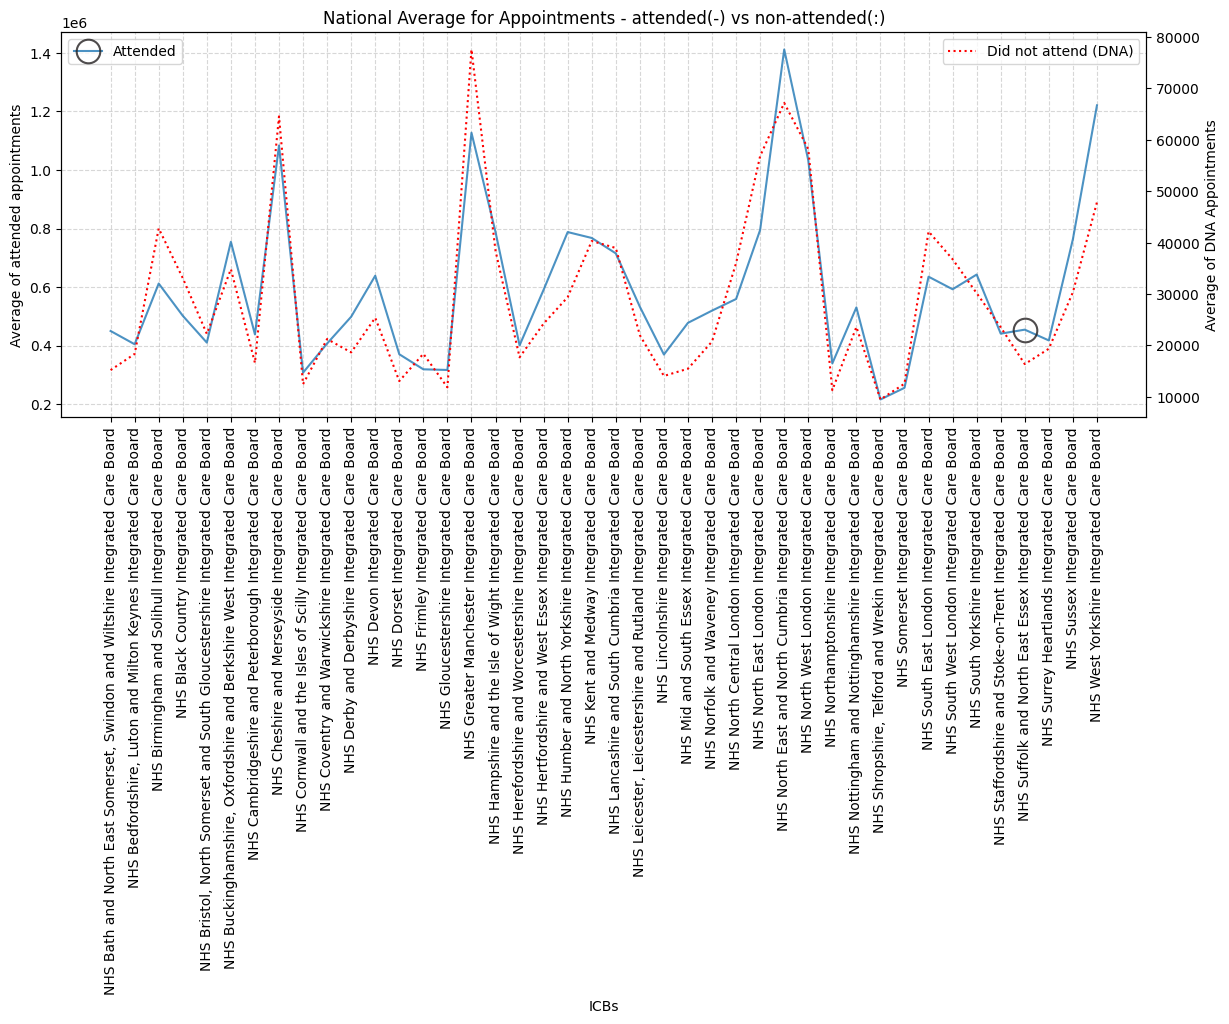

In [72]:
attended_df_mean2 = attended_df_mean.groupby('ICB_NAME').mean().reset_index()
dna_df_mean2 = dna_df_mean.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

# Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df_mean2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(0.6,30000), xytext=(36,60000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')

plt.savefig(f'{plot_counter.plot_name}.png', dpi=300, bbox_inches='tight')

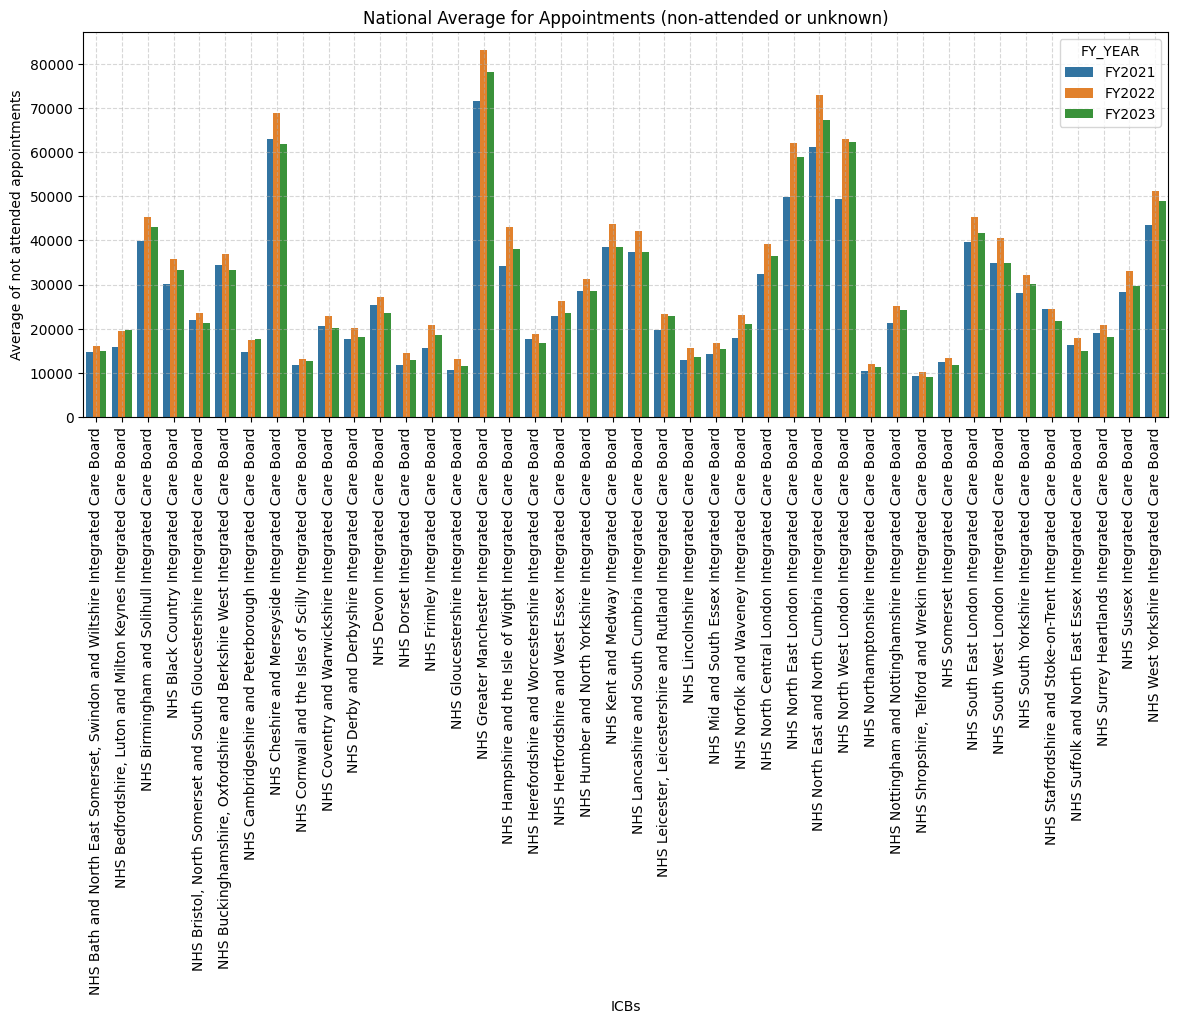

In [73]:
# Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [74]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face                3349381
                                                            Home Visit                    26843
                                                            Telephone                   2564097
                                                            Unknown                         841
                                                            Video/Online                  20199
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                   8565
                                                            Home Visit                     3256
                                                            Telephone                     64656
                                                            Unknown                     1029392
                                                            Video/Online                     85

[600 rows x 1 columns]

In [76]:
# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face                  80749
                                                                        Home Visit                      310
                                                                        Telephone                      9632
                                                                        Unknown                          46
                                                                        Video/Online                    313
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                   6785
                                                   Unknown              Face-to-Face                      4
                                                                        Home Visit                       56
                                                                        Telephone                       855
                                                                        Unknown                       30403

[564 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [77]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,176980.1667,515303.2619,1469.8611
Home visit,1436.1190,2037.5238,1645.8333
Telephone,69502.7619,59696.1429,2549.5556
Unknown,2537.5854,5231.2143,11866.6452
Video/Online,1317.1667,3285.1190,2.6667


In [78]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face                  68841
                     Home Visit                      590
                     Telephone                     16878
                     Unknown                          73
                     Video/Online                   1115
Other Practice staff Face-to-Face                 326987
                     Home Visit                     1568
                     Telephone                     17871
                     Unknown                         164
                     Video/Online                   5578
Unknown              Face-to-Face                  31603
                     Home Visit                      152
                     Telephone                        73
                     Unknown                       13097

<Axes: >

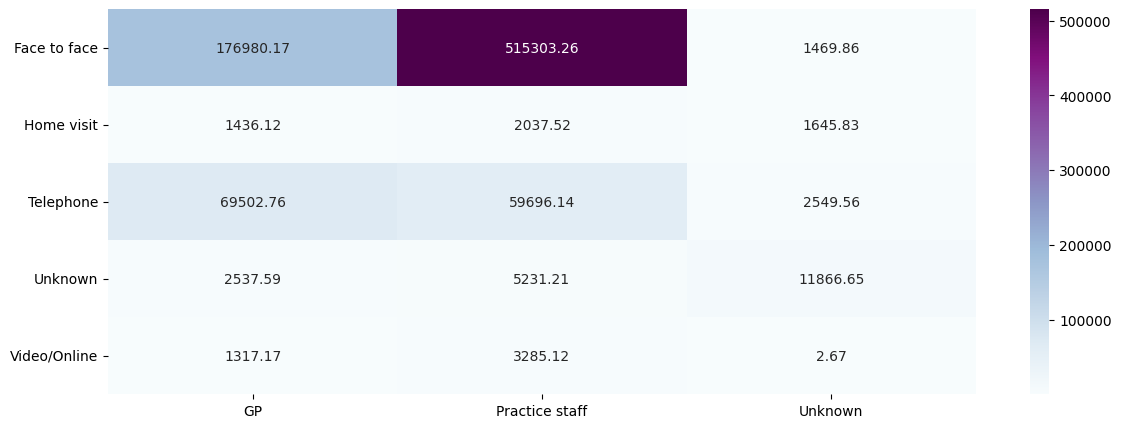

In [79]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

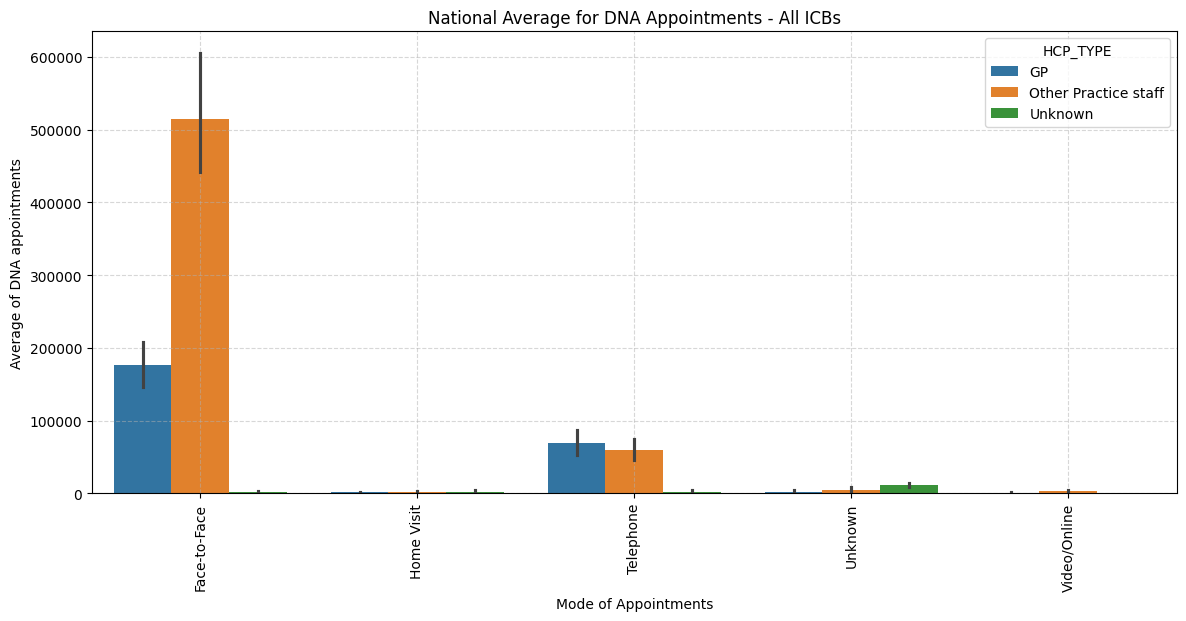

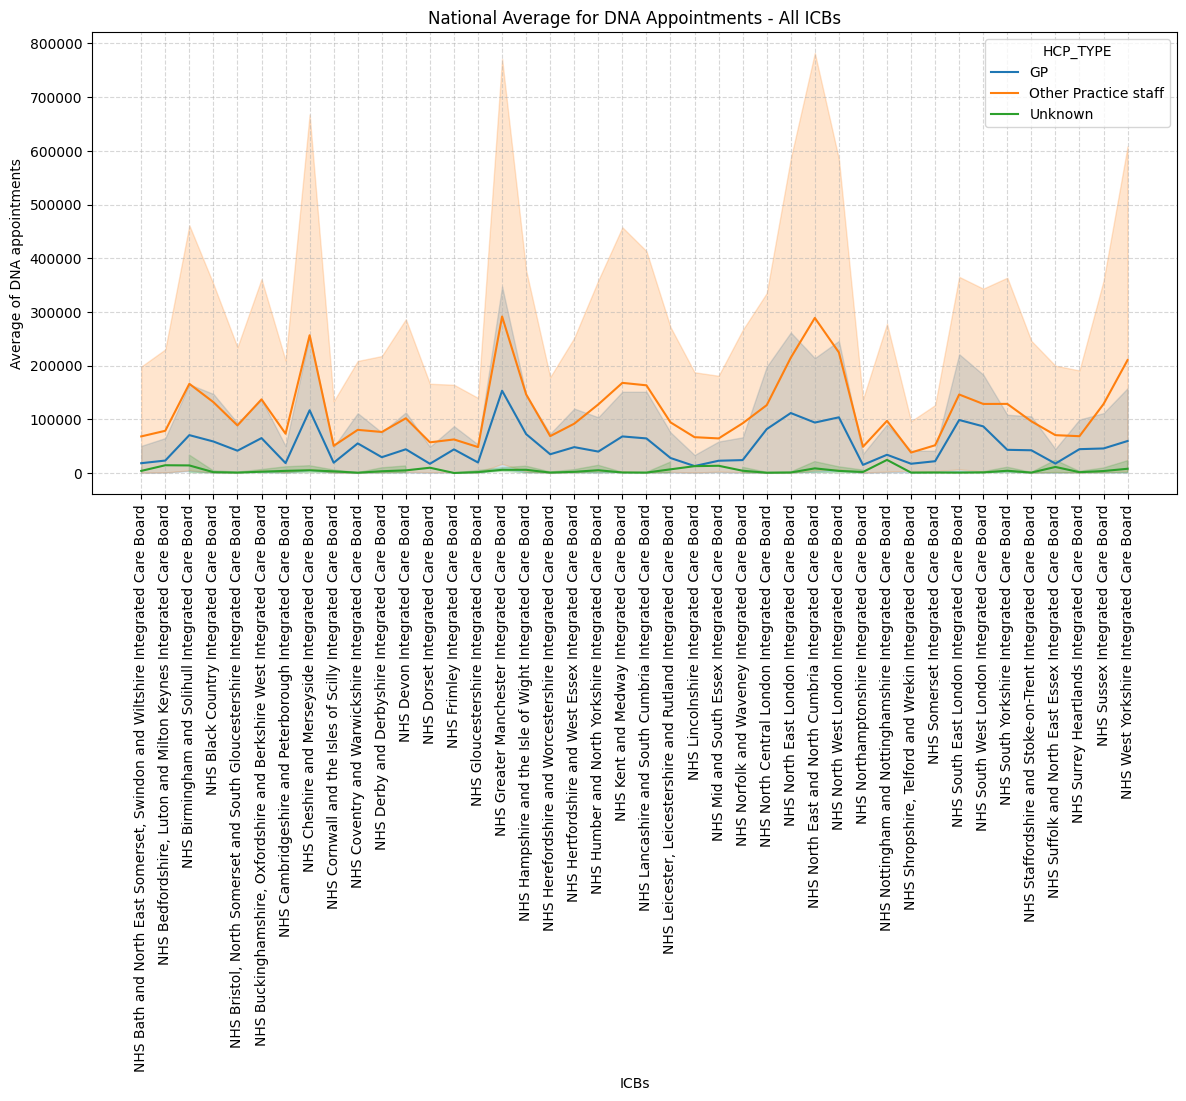

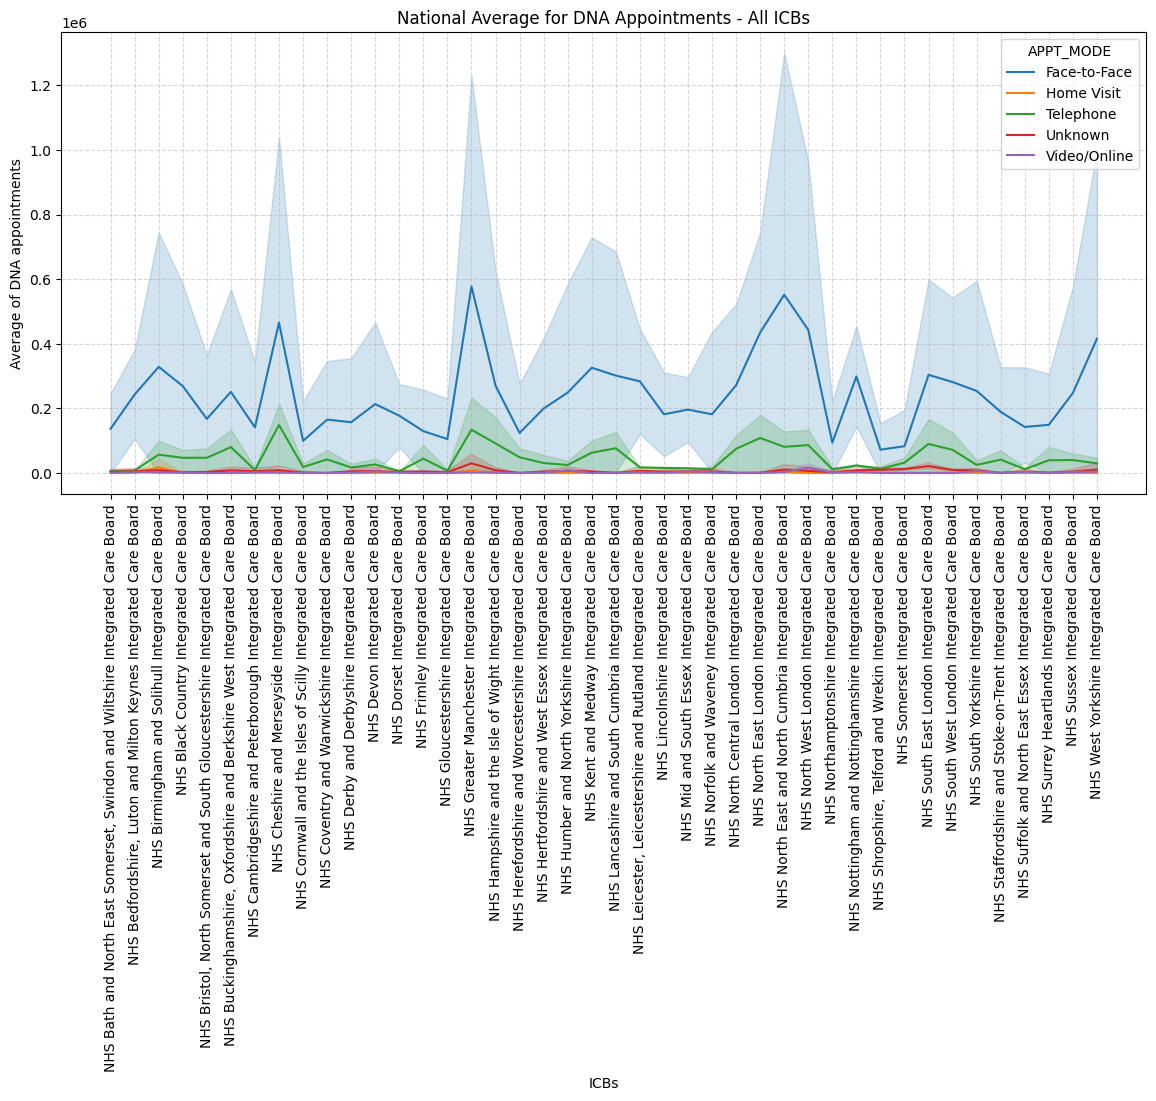

In [80]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

## **Analysis using proportion(%) of appointments**

### **Pre-Processing**

In [108]:
appt_proportion_df = combined_df_copy.loc[:,['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','FY_YEAR']].pivot_table(index=['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df = appt_proportion_df.reset_index()
appt_proportion_df.columns = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR','Attended','DNA','Unknown']
appt_proportion_df.head(50)

,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,00L,GP,Face-to-Face,APR2021,97.102330,1.385050,1.512620
1,00L,GP,Face-to-Face,APR2022,96.588637,2.115045,1.296318
2,00L,GP,Face-to-Face,APR2023,94.936068,2.137401,2.926531
3,00L,GP,Face-to-Face,AUG2021,97.402846,1.598248,0.998905
4,00L,GP,Face-to-Face,AUG2022,96.669080,2.037861,1.293059
5,00L,GP,Face-to-Face,AUG2023,95.650696,2.438103,1.911201
6,00L,GP,Face-to-Face,DEC2021,96.564563,2.142183,1.293253
7,00L,GP,Face-to-Face,DEC2022,96.456862,2.007528,1.535609
8,00L,GP,Face-to-Face,FEB2022,96.692081,2.016724,1.291195
9,00L,GP,Face-to-Face,FEB2023,96.299816,2.124290,1.575894


In [97]:
# Converting months into FY-years
proportion_yearly = make_financial_years(appt_proportion_df, 'FY_YEAR')

# Dataframe for appointments DNA
proportion_yearly = proportion_yearly.drop(columns=['HCP_TYPE','APPT_MODE']).groupby(['SUB_ICB_LOCATION_CODE','FY_YEAR']).mean().round(2)
proportion_yearly.head()

Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
00L                   FY2021      89.60  2.33    10.86
                      FY2022      88.32  2.70    11.00
                      FY2023      79.90  2.18    19.11
00N                   FY2021      83.58  4.01    14.59
                      FY2022      81.48  3.85    14.95

In [92]:
# Convert the 'count_column' to numeric
#dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')
snee_sub_icb = ['06L','06T','07K']

National_proportion_2021 = proportion_yearly.loc[slice(None),'FY2021',:].mean().round(2)
National_proportion_2022 = proportion_yearly.loc[slice(None),'FY2022',:].mean().round(2)
National_proportion_2023_april_august = proportion_yearly.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_proportion = proportion_yearly.loc[snee_sub_icb,:]


print(f'{National_proportion_2021} is the National PROPORTION for appointments(FY-2021)')
print(f'{National_proportion_2022} is the National PROPORTION for appointments(FY-2022)')
print(f'{National_proportion_2023_april_august} is the National PROPORTION for appointments(FY-2023, april-august)')

SNEE_proportion

Attended    86.46
DNA          4.12
Unknown     11.47
dtype: float64 is the National PROPORTION for appointments(FY-2021)
Attended    86.58
DNA          3.96
Unknown     11.33
dtype: float64 is the National PROPORTION for appointments(FY-2022)
Attended    78.83
DNA          3.26
Unknown     21.83
dtype: float64 is the National PROPORTION for appointments(FY-2023, april-august)


Attended    DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                          
06L                   FY2021      93.40   2.69     5.00
                      FY2022      93.40   3.58     4.00
                      FY2023      84.05   2.14    14.01
06T                   FY2021      84.76  10.40     5.56
                      FY2022      84.87   9.75     5.78
                      FY2023      79.06   3.56    18.81
07K                   FY2021      89.65   2.88    11.42
                      FY2022      90.74   4.04    10.52
                      FY2023      80.22   1.96    20.98

### **Attended Appointments** 

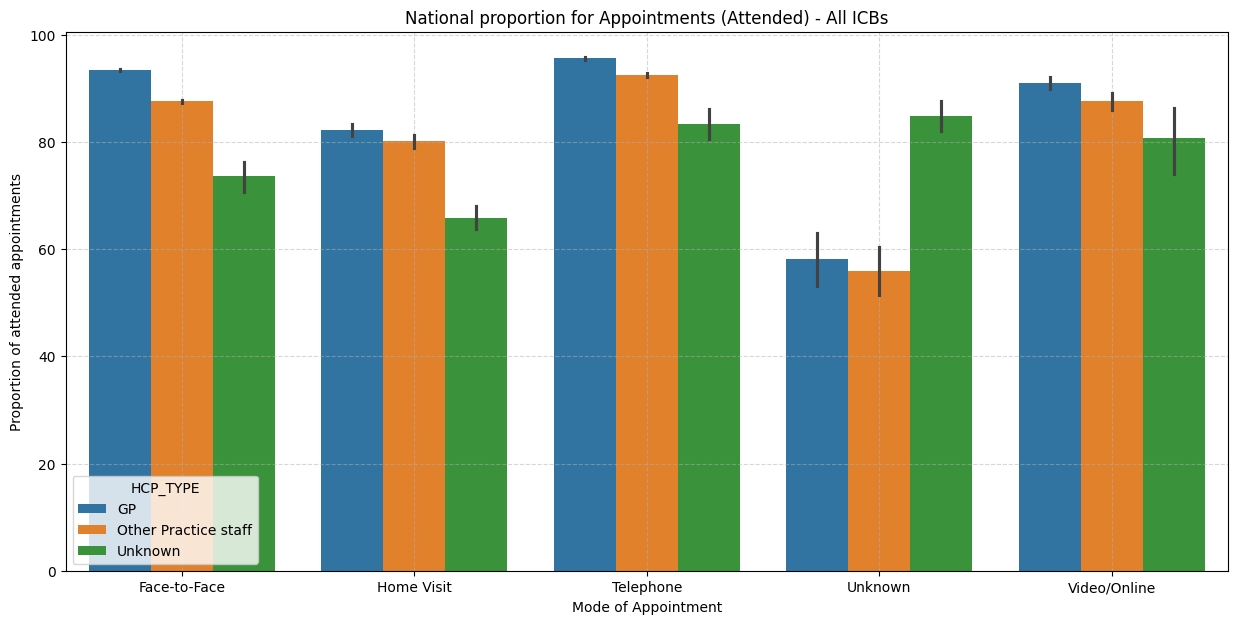

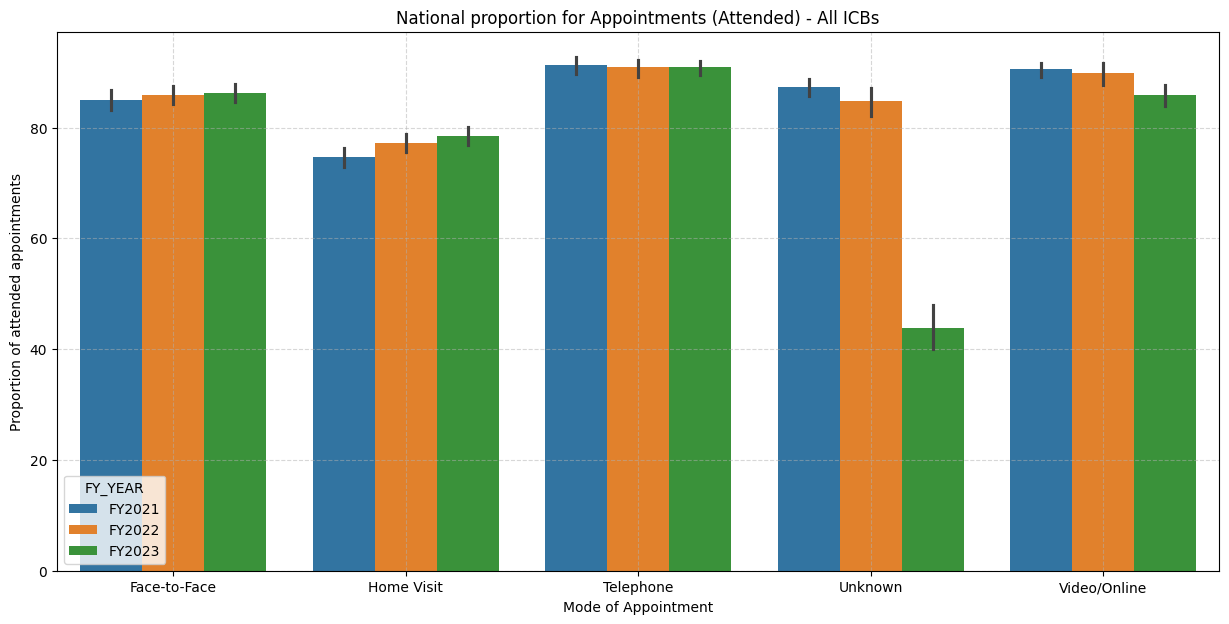

In [ ]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

### **DNA Appointments** 

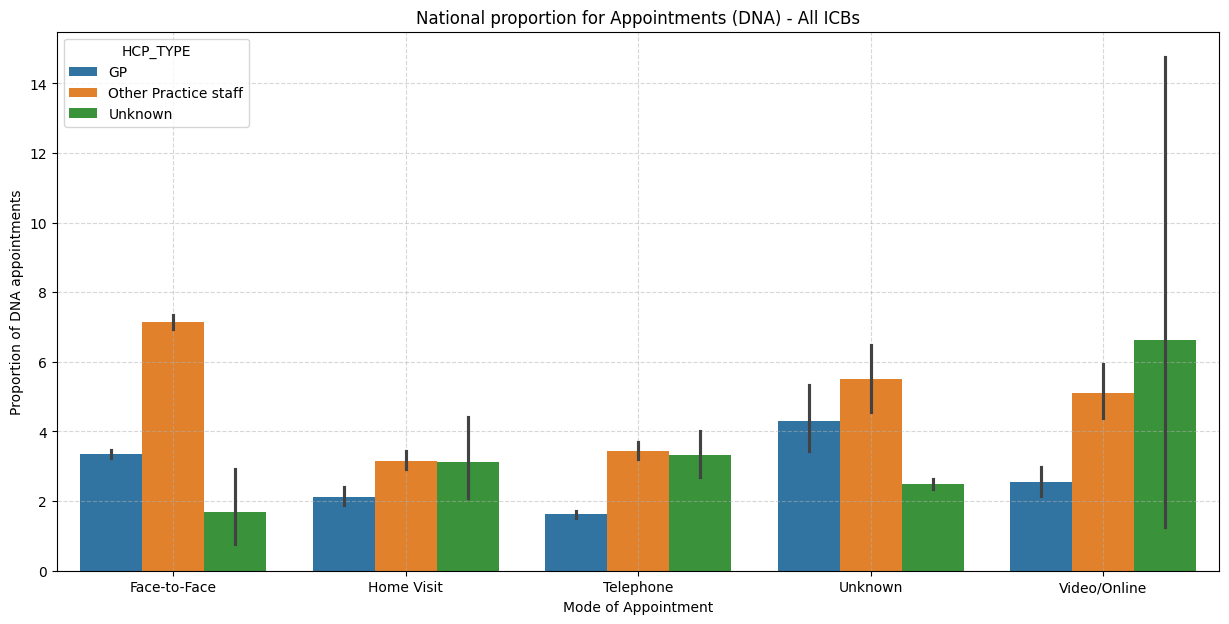

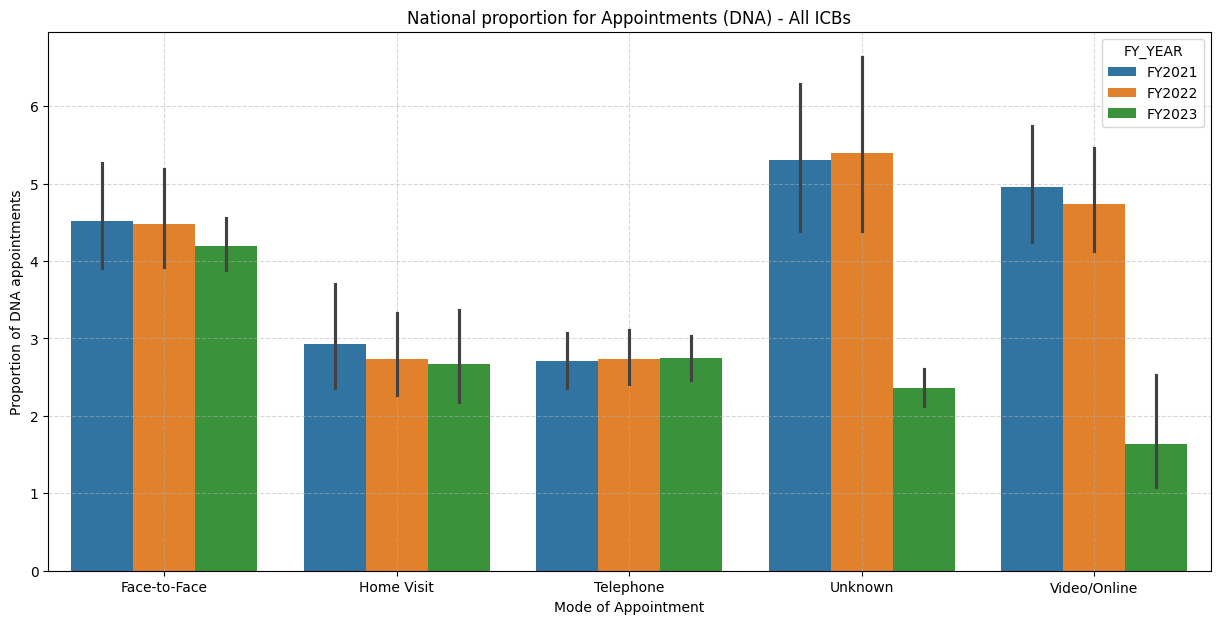

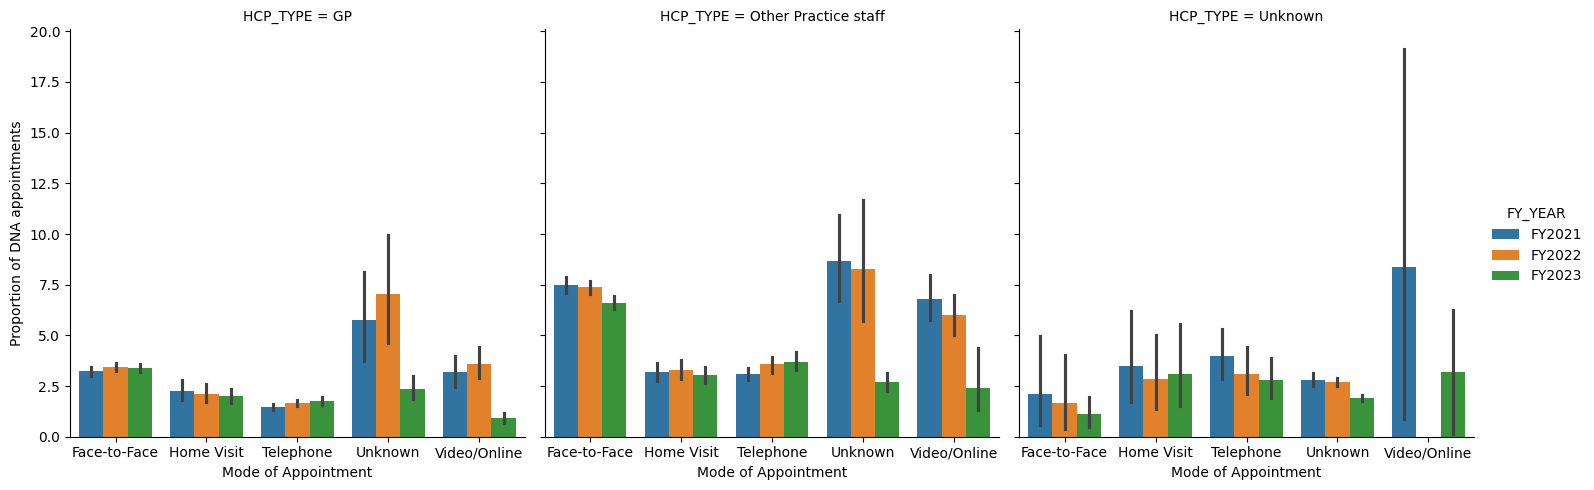

In [ ]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

### **Correlation matrix all sub-icb's**

In [ ]:
# Select categorical columns
categorical_columns = ['SUB_ICB_LOCATION_CODE', 'HCP_TYPE', 'APPT_MODE']

# Convert categorical columns to one-hot encoded features
one_hot_encoded = pd.get_dummies(appt_proportion_df[categorical_columns])

dna_correlations_all_sub_icbs = one_hot_encoded.corrwith(appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.218350
SUB_ICB_LOCATION_NAME_NHS Birmingham and Solihull ICB - 15E                               0.156437
APPT_MODE_Face-to-Face                                                                    0.107360
SUB_ICB_LOCATION_NAME_NHS Suffolk and North East Essex ICB - 06T                          0.085231
SUB_ICB_LOCATION_NAME_NHS Black Country ICB - D2P2L                                       0.059735
SUB_ICB_LOCATION_NAME_NHS Staffordshire and Stoke-on-Trent ICB - 05Q                      0.059042
SUB_ICB_LOCATION_NAME_NHS Hertfordshire and West Essex ICB - 07H                          0.052528
APPT_MODE_Unknown                                                                         0.047271
SUB_ICB_LOCATION_NAME_NHS North East and North Cumbria ICB - 00P                          0.039740
SUB_ICB_LOCATION_NAME_NHS Cheshire and Merseyside ICB - 27D                               0.037359
SUB_ICB_LO

### **SNEE sub-icb Analysis**

In [ ]:
snee_sub_icb = ['06L','06T','07K']
snee_appt_proportion_df = appt_proportion_df.loc[appt_proportion_df['SUB_ICB_LOCATION_CODE'].isin(snee_sub_icb)]
snee_appt_proportion_df['SUB_ICB_LOCATION_CODE'] = snee_appt_proportion_df['SUB_ICB_LOCATION_CODE'].replace({'NHS Suffolk and North East Essex ICB - 06L':'Ipswich & East Suffolk',
                                                                                                             'NHS Suffolk and North East Essex ICB - 06T':'North East Essex',
                                                                                                             'NHS Suffolk and North East Essex ICB - 07K':'West Suffolk'})
snee_appt_proportion_df = snee_appt_proportion_df.groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()

/tmp/ipykernel_5444/2208392011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'] = snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'].replace({'NHS Suffolk and North East Essex ICB - 06L':'Ipswich & East Suffolk',


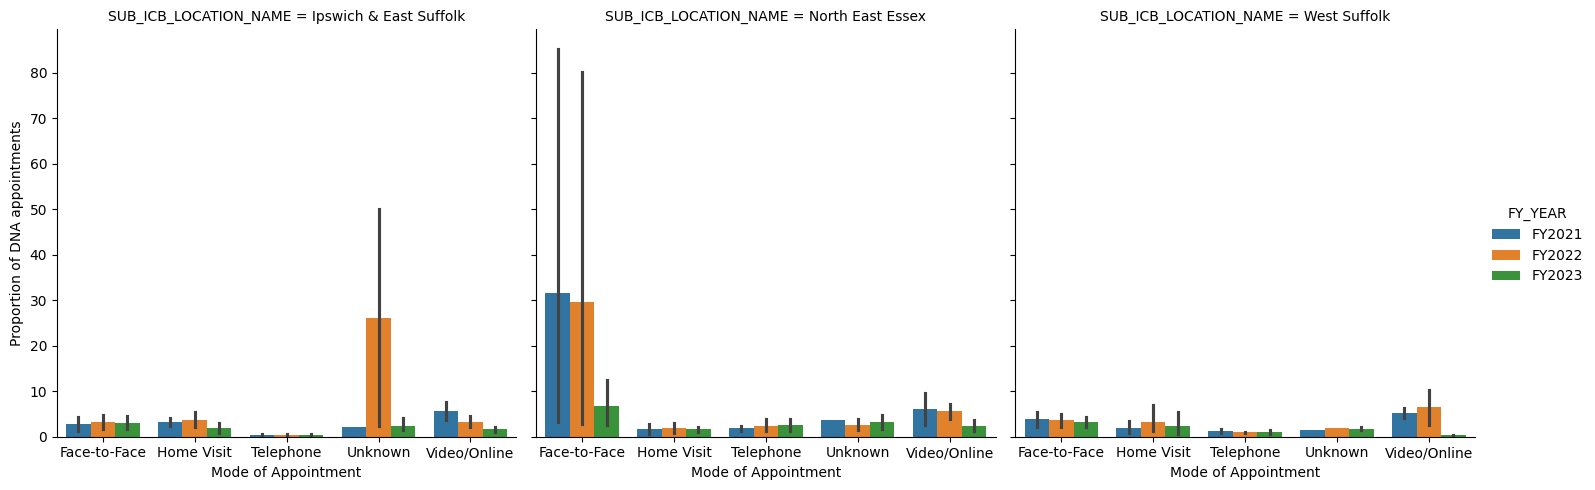

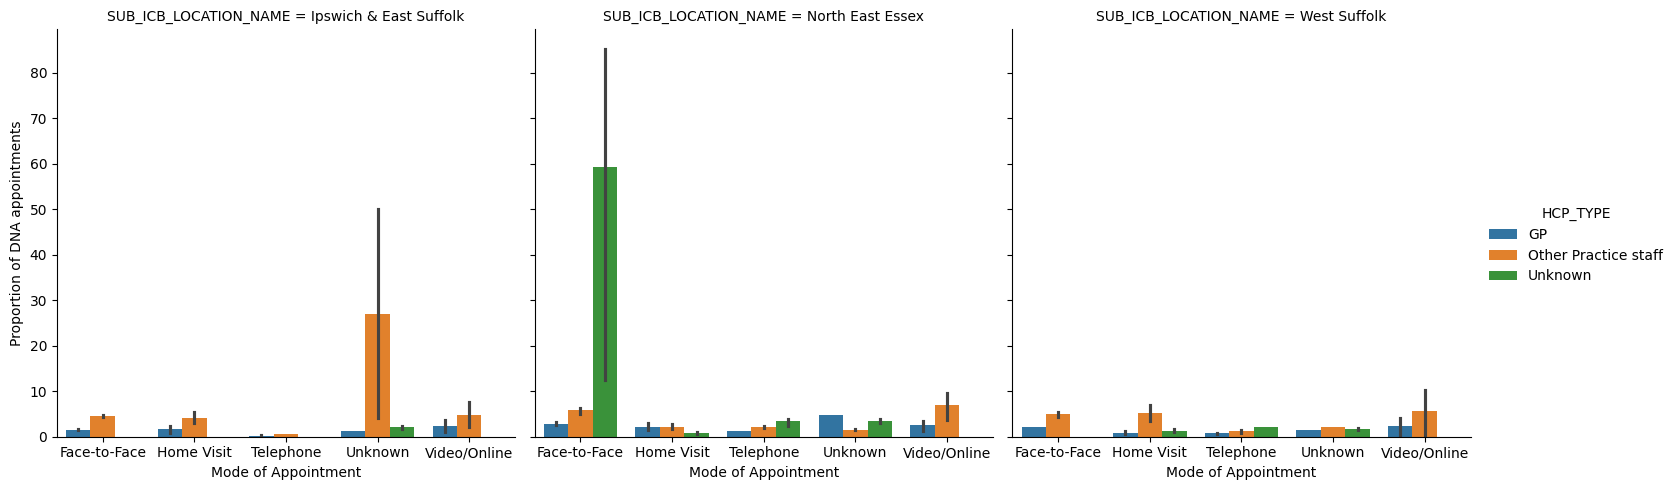

In [ ]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

In [ ]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

### **Correlation matrix SNEE sub-icb's**

In [ ]:
# Convert categorical columns to one-hot encoded features
ce_OHE = pd.get_dummies(snee_appt_proportion_df[categorical_columns])

dna_correlations_snee_icbs = ce_OHE.corrwith(snee_appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face                          0.283448
HCP_TYPE_Unknown                                0.220149
SUB_ICB_LOCATION_NAME_North East Essex          0.162989
APPT_MODE_Unknown                               0.014059
HCP_TYPE_Other Practice staff                   0.009638
APPT_MODE_Video/Online                         -0.028370
SUB_ICB_LOCATION_NAME_Ipswich & East Suffolk   -0.041996
APPT_MODE_Home Visit                           -0.113701
SUB_ICB_LOCATION_NAME_West Suffolk             -0.128406
APPT_MODE_Telephone                            -0.147838
HCP_TYPE_GP                                    -0.196048
dtype: float64


## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [ ]:
print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

27252.8 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
29004.74 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,16323.2
FY2022,17822.6
FY2023,14968.0


- We can see that the each year's average for non-attended appointments for SNEE-ICB is much lesser than National Average.
  
- For year 2022, this difference increases as the National average is 31,568.7, whereas for SNEE-ICB it is 17,822.6

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

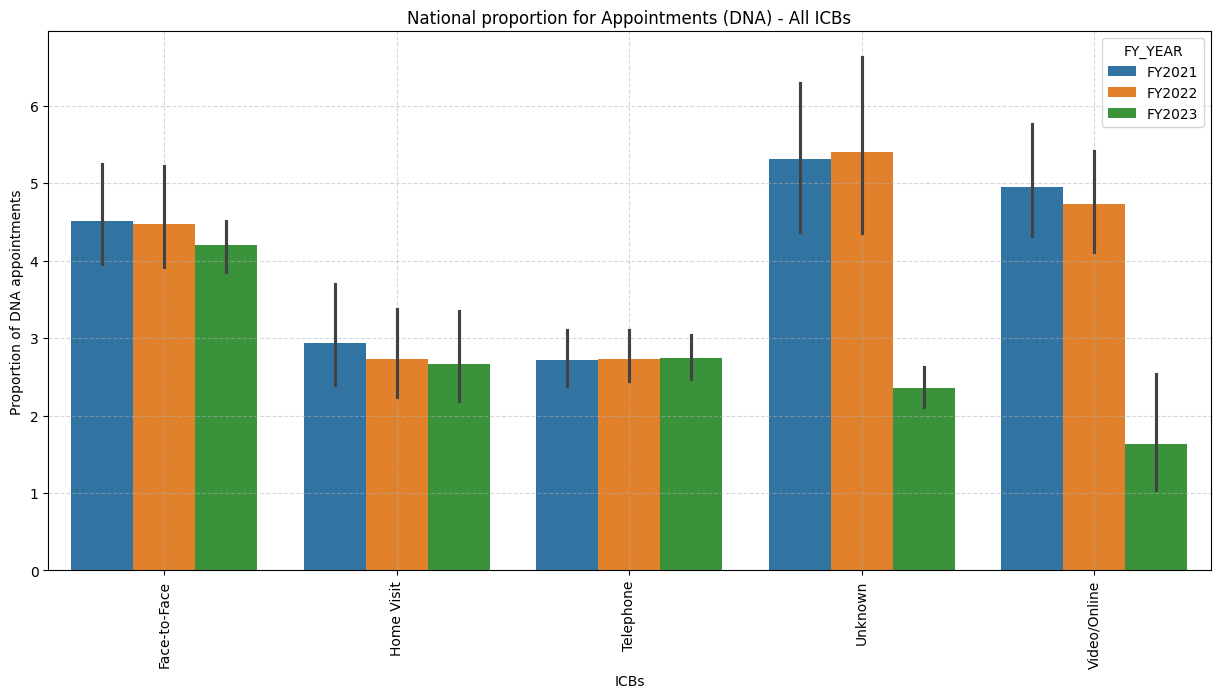

In [ ]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

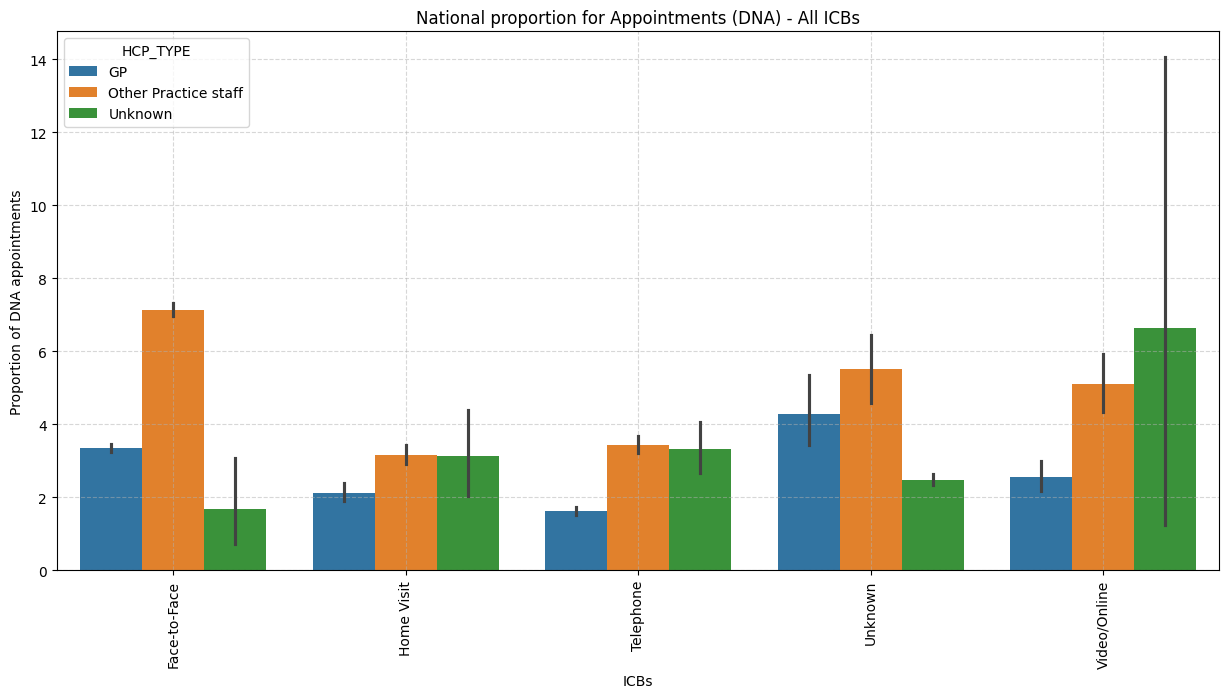

In [ ]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
5. to determine if a patient with the above appointment will attend.

#### 1. **For Snee ICB'S**

In [ ]:
print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face                          0.283448
HCP_TYPE_Unknown                                0.220149
SUB_ICB_LOCATION_NAME_North East Essex          0.162989
APPT_MODE_Unknown                               0.014059
HCP_TYPE_Other Practice staff                   0.009638
APPT_MODE_Video/Online                         -0.028370
SUB_ICB_LOCATION_NAME_Ipswich & East Suffolk   -0.041996
APPT_MODE_Home Visit                           -0.113701
SUB_ICB_LOCATION_NAME_West Suffolk             -0.128406
APPT_MODE_Telephone                            -0.147838
HCP_TYPE_GP                                    -0.196048
dtype: float64


- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment mode= (1 or Face-to-face) and HCP-TYPE= (3 or Unknown), then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP-TYPE = (1 or GP), then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### 2. **For all sub-icbs(102)**

In [ ]:
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.218350
SUB_ICB_LOCATION_NAME_NHS Birmingham and Solihull ICB - 15E                               0.156437
APPT_MODE_Face-to-Face                                                                    0.107360
SUB_ICB_LOCATION_NAME_NHS Suffolk and North East Essex ICB - 06T                          0.085231
SUB_ICB_LOCATION_NAME_NHS Black Country ICB - D2P2L                                       0.059735
SUB_ICB_LOCATION_NAME_NHS Staffordshire and Stoke-on-Trent ICB - 05Q                      0.059042
SUB_ICB_LOCATION_NAME_NHS Hertfordshire and West Essex ICB - 07H                          0.052528
APPT_MODE_Unknown                                                                         0.047271
SUB_ICB_LOCATION_NAME_NHS North East and North Cumbria ICB - 00P                          0.039740
SUB_ICB_LOCATION_NAME_NHS Cheshire and Merseyside ICB - 27D                               0.037359
SUB_ICB_LO

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 6. Persist the distribution information from 5. to a yaml file.

In [ ]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [ ]:
months_to_keep = ['SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023', 'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023']

filtered_df = combined_df[combined_df['APPOINTMENT_MONTH'].isin(months_to_keep)]

filtered_df = filtered_df.loc[:,['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = filtered_df.sum(axis=1)
filtered_df = filtered_df.div(sum_row, axis=0).round(4)

filtered_df = filtered_df.drop(columns=[('COUNT_OF_APPOINTMENTS', 'Attended'),('COUNT_OF_APPOINTMENTS',  'Unknown')])
filtered_df.columns = filtered_df.columns.to_flat_index()
filtered_df.rename(columns={('COUNT_OF_APPOINTMENTS', 'DNA'): 'DNA'}, inplace=True)
filtered_df

DNA
SUB_ICB_LOCATION_NAME                              HCP_TYPE             APPT_MODE           
NHS Bath and North East Somerset Swindon and Wi... GP                   Face-to-Face  0.0245
                                                                        Home Visit    0.0096
                                                                        Telephone     0.0033
                                                                        Unknown       0.0219
                                                                        Video/Online  0.0129
...                                                                                      ...
NHS West Yorkshire ICB - X2C4Y                     Other Practice staff Telephone     0.0097
                                                                        Unknown       0.0428
                                                                        Video/Online  0.0423
                                                   Unknown              Face-to-Face     NaN
                                                                        Unknown       0.0306

[1449 rows x 1 columns]

In [ ]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [ ]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    icb_name, hcp_type, appt_mode = key
    icb_name, icb_code = icb_name.split(' - ')
    if icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[icb_code]:
        nested_dna_proportion_dict[icb_code][hcp_type] = {}
    nested_dna_proportion_dict[icb_code][hcp_type][appt_mode] = value

In [ ]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_dna_proportion_dict, yaml_file)